We were getting lots of false positives in the week01 model when testing on a full day recording. We have different theories of what could be going wrong.
Here we will test if when keeping the NO "low" Movement windows for daily sampling will help with false positives.
We do by the following:

- train normal model (call it model 00) removing No movements
- train model (call it model 01) NOT removing "no movements"
- eval model 01 on daily data that does not contain no movement data

In [18]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
import sys
import os

sys.path.append(os.path.abspath('..')) #so we can import for the dir above
from combined_data_script import get_data
from medication_data_script import LeakageOption
from RegNet import RegNet
from utils import train_loop, eval_loop

**train model00** (the one with NO Movment windows removed)

In [2]:
data_dic = get_data(flatten=False,leakage_option=LeakageOption.FULL_LEAKAGE, stride=50, filter_static=True)
train, dev, test = data_dic['train'], data_dic['dev'], data_dic['test'] 
len(train), len(dev), len(test) #note it is NOT shuffled we will nedd to do this 

(10426, 1302, 1306)

In [3]:
#important that we shuffle THEY ARE NOT IF WE DONT
torch.manual_seed(69)
train_loader = DataLoader(train, batch_size=64, shuffle=True)
dev_loader = DataLoader(dev, batch_size=2048, shuffle=True)

In [4]:
dropout = 0.85
model = RegNet(dropout=dropout)

device = "cuda:0"
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer =  torch.optim.AdamW(model.parameters(), lr=0.0003, weight_decay=0.01)

start


100%|██████████| 50/50 [01:13<00:00,  1.47s/it]

best dev loss is 0.2794


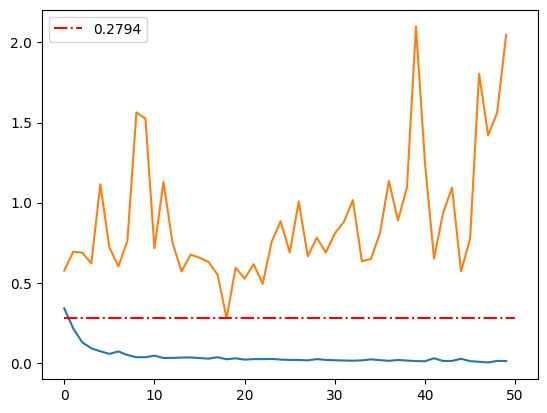

In [6]:
best_model = train_loop(model, device, optimizer, criterion, train_loader, dev_loader, dropout=dropout, epochs=50)

In [45]:
X, y = next(iter(dev_loader))
X.shape, y.shape

(torch.Size([1302, 6, 400]), torch.Size([1302, 1]))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94       651
           1       0.91      0.98      0.94       651

    accuracy                           0.94      1302
   macro avg       0.94      0.94      0.94      1302
weighted avg       0.94      0.94      0.94      1302



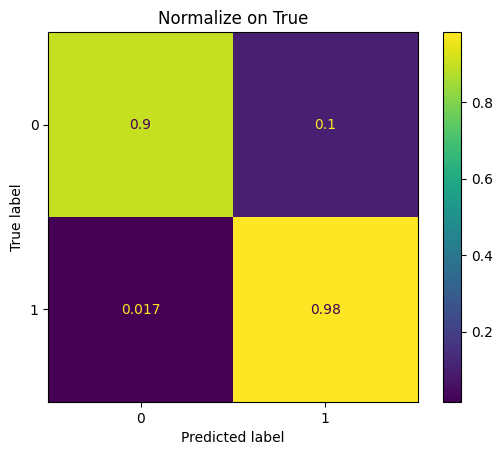

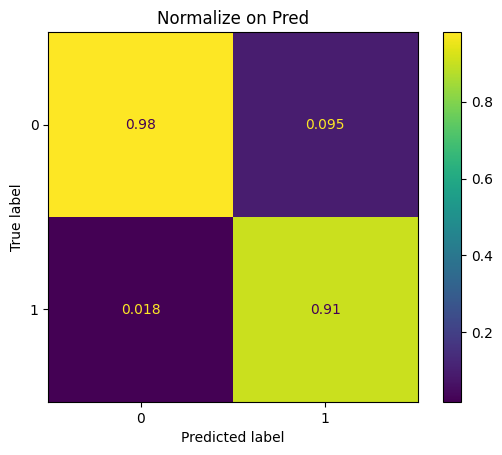

In [46]:
eval_loop(best_model, X, y)

Nice results! We will save the model then in the next notebook we will evaluate it to see how many false positives.

In [ ]:
# torch.save(best_model.state_dict(), '94f1_ACIDENTALSAVEnoNOMovments.pth') 

_________

We now train the next model but this one WILL have NO Movments in it's train set

In [48]:
data_dic = get_data(flatten=False,leakage_option=LeakageOption.FULL_LEAKAGE, stride=50, filter_static=False)
train, dev, test = data_dic['train'], data_dic['dev'], data_dic['test'] 
len(train), len(dev), len(test) #note it is NOT shuffled we will nedd to do this 

(10426, 1302, 1306)

In [54]:
#important that we shuffle THEY ARE NOT IF WE DONT
torch.manual_seed(69)
train_loader = DataLoader(train, batch_size=64, shuffle=True)
dev_loader = DataLoader(dev, batch_size=2048, shuffle=True)

In [55]:
dropout = 0.85
model = RegNet(dropout=dropout)

device = "cuda:0"
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer =  torch.optim.AdamW(model.parameters(), lr=0.0003, weight_decay=0.01)

start


100%|██████████| 50/50 [01:16<00:00,  1.52s/it]

best dev loss is 0.2857


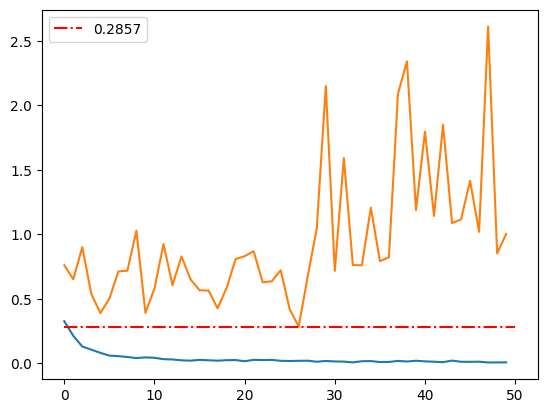

In [56]:
best_model = train_loop(model, device, optimizer, criterion, train_loader, dev_loader, dropout=dropout, epochs=50)

In [57]:
X, y = next(iter(dev_loader))
X.shape, y.shape

(torch.Size([1302, 6, 400]), torch.Size([1302, 1]))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94       651
           1       0.92      0.97      0.94       651

    accuracy                           0.94      1302
   macro avg       0.94      0.94      0.94      1302
weighted avg       0.94      0.94      0.94      1302



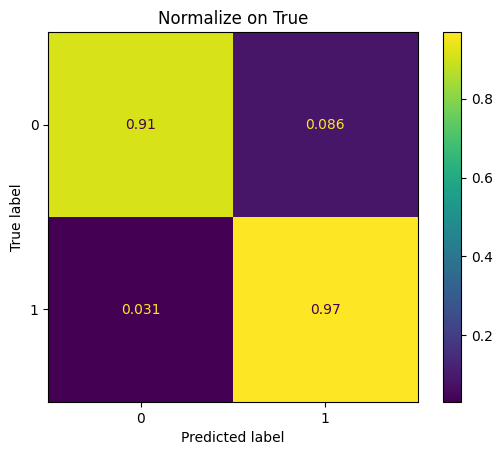

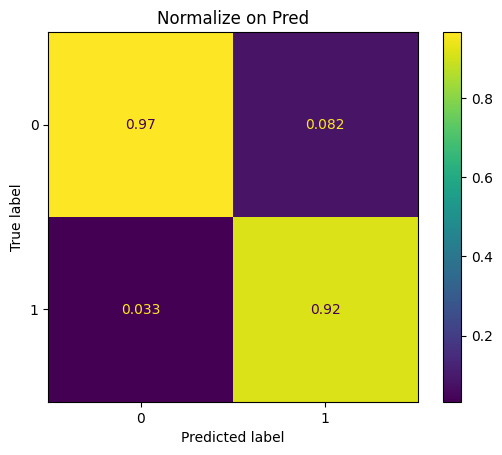

In [58]:
eval_loop(best_model, X, y)

In [ ]:
# torch.save(best_model.state_dict(), '94f1_ACIDENTALSAVENOMovments.pth') 